# Przewidywanie bankructwa polskich przedsiębiorstw

Celem projektu jest zbudowanie modelu klasyfikacyjnego, który na podstawie wskaźników finansowych przewidzi upadłość firmy.


### Importowanie bibliotek i konfiguracja środowiska


In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import wandb
import joblib
import json
from scipy.io import arff
from dotenv import load_dotenv

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_recall_curve,
    f1_score,
)
from xgboost import XGBClassifier

from utils.attributes import attributes_pl

# Ustawienia wyświetlania
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-whitegrid")

# Ustawienia kolorów
COLOR_HEALTHY = "#1f77b4"
COLOR_BANKRUPT = "#d62728"
BINARY_PALETTE = [COLOR_HEALTHY, COLOR_BANKRUPT]
PALETTE_DICT = {"Zdrowa": COLOR_HEALTHY, "Bankrut": COLOR_BANKRUPT}
CMAP_DIVERGING = mcolors.LinearSegmentedColormap.from_list(
    "CustomRdBu", [COLOR_HEALTHY, "white", COLOR_BANKRUPT]
)
CMAP_CONFUSION = sns.light_palette(COLOR_HEALTHY, as_cmap=True)
CMAP_IMPORTANCE = sns.light_palette(COLOR_HEALTHY, n_colors=10, reverse=True)

YEAR_TO_ANALYZE = 3  # od 1 do 5
print(f"Analizowany rok: {YEAR_TO_ANALYZE}")

# Import słownika
try:
    from utils.attributes import attributes_pl
except ImportError:
    attributes_pl = {}

# Załadowanie zmiennych środowiskowych
load_dotenv()

# Zalogowanie do WandB
api_key = os.getenv("WANDB_API_KEY")

if not api_key:
    print("UWAGA: Nie znaleziono WANDB_API_KEY")

try:
    print("Logowanie do WandB...")
    wandb.login(key=api_key)
    print("Zalogowano pomyślnie")
except Exception as e:
    print(f"BŁĄD: Nieudana próba logowania do WandB: {e}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jakub/.netrc


Analizowany rok: 3
Logowanie do WandB...


wandb: Currently logged in as: scbpls (polish-bankruptcy-prediction) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Zalogowano pomyślnie


## Część 1: Inżynieria danych i model bazowy

1.  **Wczytanie i unifikacja danych:** Wczytanie plików `.arff` i unifikacja.
2.  **Eksploracyjna analiza danych (EDA):** Zrozumienie danych, braków i korelacji.
3.  **Przetworzenie i podział danych:** Czyszczenie, podział, imputacja i skalowanie danych.
4.  **Analiza głównych składowych (PCA):** Redukcja wymiarowości.
5.  **Model bazowy (baseline):** Budowa prostego modelu odniesienia (regresja logistyczna).


### Wczytanie i unifikacja danych

Wczytanie danych z pliku `.arff`. Dane zawierają wskaźniki finansowe (Attr1 - Attr64) oraz etykietę klasy (`class`), gdzie:

- `0` - firma zdrowa
- `1` - bankrut

Następnie dane są dzielone zbiór na treningowy i testowy (proporcja 80/20).


In [2]:
file_path = f"data/{YEAR_TO_ANALYZE}year.arff"

try:
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)

    df["class"] = df["class"].astype(int)

    print(f"Wczytano dane dla roku {YEAR_TO_ANALYZE}")
    print(f"Wymiary: {df.shape[0]} wierszy, {df.shape[1]} kolumn")

    display(df.head(5))

except FileNotFoundError:
    print(f"BŁĄD: Nie odnaleziono pliku: {file_path}")

Wczytano dane dla roku 3
Wymiary: 10503 wierszy, 65 kolumn


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,0.219460,0.531390,0.142330,0.219460,592.24,0.61630,2.4213,0.219460,0.122720,37.573,0.99690,0.295100,0.097402,0.75641,0.46359,0.50669,1.97370,0.32417,5.9473,0.224930,0.122720,100.820,3.6203,0.71453,0.295100,1.8079,123140.0000,0.46359,0.165010,0.212820,0.041124,0.165010,95.682,58.109,0.946210,0.90221,44.941,0.260030,0.145400,1.3480,0.41299,0.27622,1.0457,1.0458,127280.0,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,0.175790,0.383170,0.126470,0.171850,829.46,0.44004,2.1721,0.171850,0.107280,60.954,5.08890,0.175710,0.091295,NaN,0.17523,0.38442,44.59300,1.04860,4.0792,0.243840,0.109740,105.090,3.4733,3.38360,0.044076,1.6018,NaN,0.53962,0.027516,0.164060,0.074333,0.109690,149.750,88.801,0.546690,1.03300,62.678,0.144970,0.090503,1.5874,0.44849,0.28791,2.0044,2.0044,3387.8,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,0.004572,0.020219,0.030966,0.004572,2094.10,0.17430,4.4225,0.004572,0.003592,53.881,0.67451,0.040610,0.000468,0.23470,0.67566,0.15672,0.32153,1.71070,4.6220,0.036196,0.003592,65.345,5.5857,0.17960,0.040610,1.3425,NaN,0.67566,0.031907,0.844690,0.098528,0.031907,150.130,96.251,0.003168,2.32900,54.296,0.005769,0.004533,3.1599,0.22612,0.17903,2.3667,2.3667,20453.0,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,0.024526,0.069747,0.036812,0.024526,3299.40,0.11063,2.3129,0.024526,0.018876,86.317,0.62795,0.055446,0.018876,0.56944,0.56453,0.11063,0.44844,0.73869,4.2600,0.286240,0.018876,103.810,3.5161,0.12824,0.055446,1.3068,3.9624,0.64524,0.042673,0.178260,0.180500,0.042673,158.550,72.237,0.079819,0.90954,90.707,0.032141,0.024737,1.4504,0.35164,0.28440,1.5139,1.7303,5012.6,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,0.238810,0.633170,0.187800,0.233580,602.31,0.60600,2.4094,0.233580,0.174410,140.860,1.20390,0.234930,0.140590,0.00000,0.57250,0.49687,44.94700,1.18530,4.6033,0.306910,0.177840,122.090,2.9897,2.65740,0.236350,1.3393,4.5490,0.62769,0.176480,0.013769,0.054712,0.175420,192.450,51.585,0.364290,0.52685,171.050,0.216990,0.162030,1.7136,0.36891,0.33449,2.0256,2.1735,13730.0,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


### Eksploracyjna analiza danych (EDA)

1.  **Analiza braków danych:** Sprawdzenie, które wskaźniki finansowe są najczęściej niekompletne.
2.  **Rozkład klas:** Weryfikacja, jak bardzo niezbalansowany jest zbiór (stosunek firm zdrowych do bankrutów).
3.  **Korelacje:** Szukanie cech, które mają najsilniejszy związek (dodatni lub ujemny) z bankructwem.


/tmp/ipykernel_134184/1420746644.py:10: UserWarning: The palette list has more values (25) than needed (20), which may not be intended.
  ax = sns.barplot(


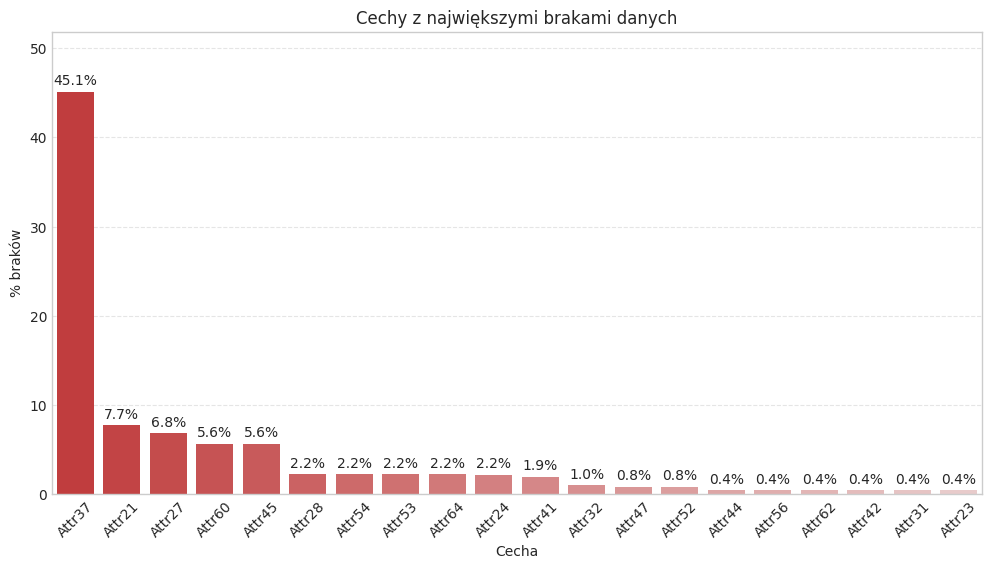

LEGENDA
Attr37: (aktywa obrotowe - zapasy) / zobowiązania długoterminowe
Attr21: przychody ze sprzedaży (n) / przychody ze sprzedaży (n-1)
Attr27: zysk z działalności operacyjnej / koszty finansowe
Attr60: przychody ze sprzedaży / zapasy
Attr45: zysk netto / zapasy
Attr28: kapitał obrotowy / aktywa trwałe
Attr54: kapitał stały / aktywa trwałe
Attr53: kapitał własny / aktywa trwałe
Attr64: przychody ze sprzedaży / aktywa trwałe
Attr24: zysk brutto (w 3 lata) / aktywa ogółem
Attr41: zobowiązania ogółem / ((zysk z dział. operacyjnej + amortyzacja) * (12/365))
Attr32: (zobowiązania bieżące * 365) / koszt własny sprzedaży
Attr47: (zapasy * 365) / koszt własny sprzedaży
Attr52: (zobowiązania krótkoterminowe * 365) / koszt własny sprzedaży
Attr44: (należności * 365) / przychody ze sprzedaży
Attr56: (przychody ze sprzedaży - koszt własny sprzedaży) / przychody ze sprzedaży
Attr62: (zobowiązania krótkoterminowe * 365) / przychody ze sprzedaży
Attr42: zysk z działalności operacyjnej / przychody 

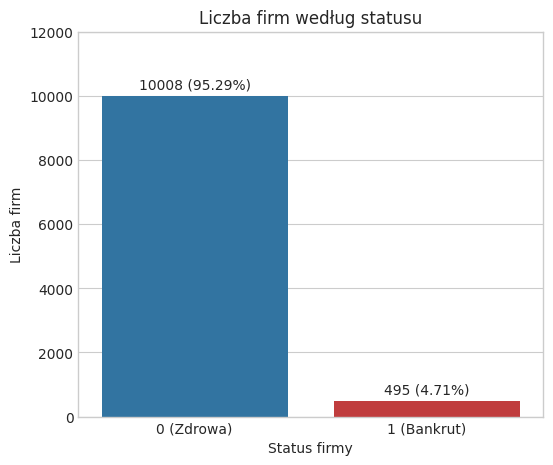

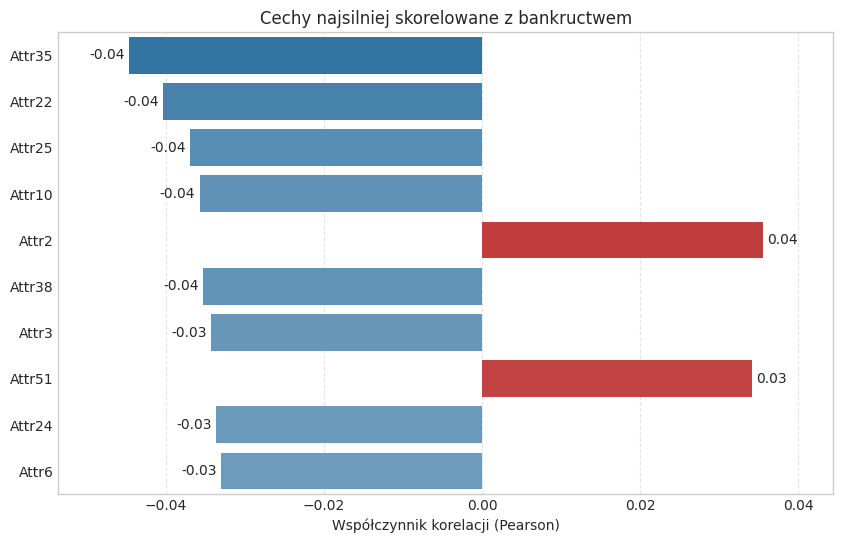

LEGENDA
Attr35: zysk na sprzedaży / aktywa ogółem
Attr22: zysk z działalności operacyjnej / aktywa ogółem
Attr25: (kapitał własny - kapitał zakładowy) / aktywa ogółem
Attr10: kapitał własny / aktywa ogółem
Attr2: zobowiązania ogółem / aktywa ogółem
Attr38: kapitał stały / aktywa ogółem
Attr3: kapitał obrotowy / aktywa ogółem
Attr51: zobowiązania krótkoterminowe / aktywa ogółem
Attr24: zysk brutto (w 3 lata) / aktywa ogółem
Attr6: zyski zatrzymane / aktywa ogółem


In [3]:
# 1. ANALIZA BRAKÓW DANYCH
missing = df.isnull().sum() / len(df) * 100
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))

if not missing.empty:
    top_missing = missing.head(20)

    ax = sns.barplot(
        x=top_missing.index,
        y=top_missing.values,
        hue=top_missing.index,
        legend=False,
        palette=sns.light_palette(COLOR_BANKRUPT, n_colors=25, reverse=True),
    )

    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", padding=3)

    plt.title("Cechy z największymi brakami danych")
    plt.xlabel("Cecha")
    plt.ylabel("% braków")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)

    max_missing = top_missing.max()
    limit = max_missing * 1.15 if max_missing > 0 else 10

    plt.ylim(0, limit)

    plt.show()

    print("LEGENDA")
    for attr in top_missing.index[:20]:
        print(f"{attr}: {attributes_pl.get(attr, 'Brak opisu')}")
else:
    print("Brak pustych wartości")

# 2. ROZKŁAD KLAS
plt.figure(figsize=(6, 5))

ax = sns.countplot(
    x="class", data=df, hue="class", legend=False, palette=BINARY_PALETTE
)

total = len(df)

for container in ax.containers:
    labels = [
        f"{int(v.get_height())} ({v.get_height() / total * 100:.2f}%)"
        for v in container
    ]
    ax.bar_label(container, labels=labels, label_type="edge", padding=3)

plt.title("Liczba firm według statusu")
plt.xlabel("Status firmy")
plt.ylabel("Liczba firm")
plt.xticks([0, 1], ["0 (Zdrowa)", "1 (Bankrut)"])

max_height = max([p.get_height() for p in ax.patches])

plt.ylim(0, max_height * 1.2)

plt.show()

# 3. KORELACJE
correlations = df.corr()["class"].sort_values()
top_corr = correlations.abs().sort_values(ascending=False).head(11)
top_corr_names = top_corr.index.tolist()

if "class" in top_corr_names:
    top_corr_names.remove("class")

plt.figure(figsize=(10, 6))

corr_values = correlations[top_corr_names].values
norm = plt.Normalize(corr_values.min(), corr_values.max())
colors = CMAP_DIVERGING(norm(corr_values))

ax = sns.barplot(
    x=corr_values,
    y=top_corr_names,
    hue=corr_values,
    legend=False,
    palette=CMAP_DIVERGING,
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.title("Cechy najsilniej skorelowane z bankructwem")
plt.xlabel("Współczynnik korelacji (Pearson)")
plt.grid(axis="x", linestyle="--", alpha=0.5)

min_val = corr_values.min()
max_val = corr_values.max()
padding = max(abs(min_val), abs(max_val)) * 0.2

plt.xlim(min_val - padding, max_val + padding)

plt.show()

print("LEGENDA")
for attr in top_corr_names:
    print(f"{attr}: {attributes_pl.get(attr, 'Brak opisu')}")

### Przetworzenie i podział danych

Na podstawie analizy braków danych zdecydowano usunąć cechę `Attr37`, która posiada zbyt wiele pustych wartości, by je bezpiecznie uzupełniać.

Następnie:

1.  **Podział (Train/Test):** Dane dzielone są w proporcji 80/20 z zachowaniem proporcji klas (`stratify`).
2.  **Pipeline:**
    - **Imputacja:** Braki uzupełniane są medianą.
    - **Skalowanie:** Dane są standaryzowane (`StandardScaler`), co jest wymagane dla PCA i regresji logistycznej.


In [4]:
# 1. PRZYGOTOWANIE DANYCH
# Usunięcie cechy Attr37
if "Attr37" in df.columns:
    X = df.drop(["class", "Attr37"], axis=1)
    print("Usunięto kolumnę Attr37")
else:
    X = df.drop("class", axis=1)
    print("Kolumna Attr37 nie istnieje")

y = df["class"]

feature_names_final = X.columns.tolist()
print(f"Liczba cech: {X.shape[1]}")

# 2. PODZIAŁ DANYCH
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Rozmiar zbioru treningowego: {X_train.shape}")
print(f"Rozmiar zbioru testowego:  {X_test.shape}")
print(f"Liczba bankrutów w zbiorze testowym: {y_test.sum()} (na {len(y_test)} firm)")

# 3. PIPELINE PRZETWARZANIA DANYCH
preprocessor = Pipeline(
    [
        (
            "imputer",
            SimpleImputer(strategy="median"),
        ),  # mediana jest odporna na wartości odstające
        ("scaler", StandardScaler()),  # średnia=0, odchylenie=1
    ]
)

# 4. DOPASOWANIE I TRANSFORMACJA DANYCH
# Pipeline jest dopasowywany do zbioru treningowego
X_train_scaled = preprocessor.fit_transform(X_train)
# Zbiór testowy jest transformowany na podstawie parametrów wyuczonych na zbiorze treningowym
X_test_scaled = preprocessor.transform(X_test)

# Zamiana na DataFrame (dla wygody operowania nazwami kolumn)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names_final)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names_final)

Usunięto kolumnę Attr37
Liczba cech: 63
Rozmiar zbioru treningowego: (8402, 63)
Rozmiar zbioru testowego:  (2101, 63)
Liczba bankrutów w zbiorze testowym: 99 (na 2101 firm)


### Analiza głównych składowych (PCA)

Dane mają 63 wymiary, co utrudnia wizualizację. Zastosowano PCA, aby sprawdzić, czy bankruci tworzą oddzielne skupisko.


Wariancja wyjaśniona przez PC1: 16.76%
Wariancja wyjaśniona przez PC2: 12.76%
Suma informacji na wykresie: 29.52%


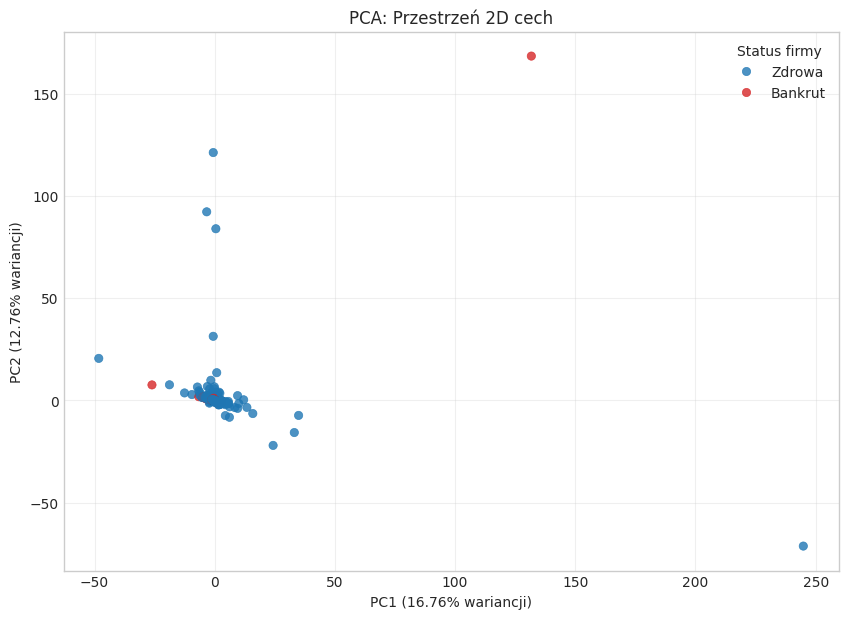

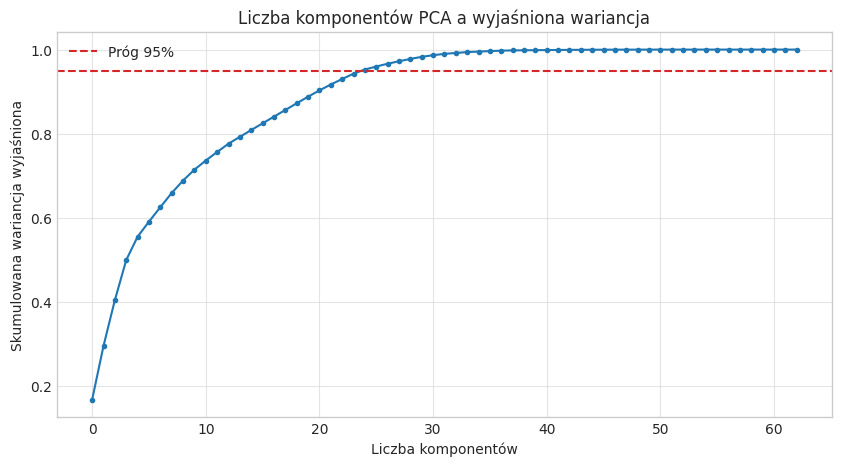

In [5]:
# 1. URUCHOMIENIE PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
df_pca["class"] = y_train.values
df_pca["Legenda"] = df_pca["class"].map({0: "Zdrowa", 1: "Bankrut"})

# 2. LICZBA WARIANCJI WYJAŚNIONEJ
evr = pca.explained_variance_ratio_
print(f"Wariancja wyjaśniona przez PC1: {evr[0]:.2%}")
print(f"Wariancja wyjaśniona przez PC2: {evr[1]:.2%}")
print(f"Suma informacji na wykresie: {sum(evr):.2%}")

# 3. WIZUALIZACJA PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="Legenda",
    data=df_pca,
    palette=PALETTE_DICT,
    alpha=0.8,
    edgecolor=None,
)
plt.title("PCA: Przestrzeń 2D cech")
plt.xlabel(f"PC1 ({evr[0]:.2%} wariancji)")
plt.ylabel(f"PC2 ({evr[1]:.2%} wariancji)")
plt.legend(title="Status firmy")
plt.grid(True, alpha=0.3)
plt.show()

# 4. WYBÓR LICZBY KOMPONENTÓW PCA
pca_full = PCA().fit(X_train_scaled)

plt.figure(figsize=(10, 5))
plt.plot(
    np.cumsum(pca_full.explained_variance_ratio_),
    marker=".",
    linestyle="-",
    color=COLOR_HEALTHY,
)
plt.xlabel("Liczba komponentów")
plt.ylabel("Skumulowana wariancja wyjaśniona")
plt.title("Liczba komponentów PCA a wyjaśniona wariancja")
plt.axhline(y=0.95, color=COLOR_BANKRUPT, linestyle="--", label="Próg 95%")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### Model bazowy (baseline): Regresja logistyczna

Jako punkt odniesienia wytrenowana została regresja logistyczna.
Używany jest parametr `class_weight="balanced"`, aby zmusić model do zwracania uwagi na mniejszą klasę bankrutów (w przeciwnym razie model mógłby ignorować bankrutów i wciąż mieć wysoką ogólną dokładność).


Trening modelu bazowego...
WYNIKI
ROC AUC: 0.7418
Recall: 0.7172
F1 Score: 0.1655
Confusion matrix:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      2002
           1       0.09      0.72      0.17        99

    accuracy                           0.66      2101
   macro avg       0.54      0.69      0.48      2101
weighted avg       0.94      0.66      0.76      2101



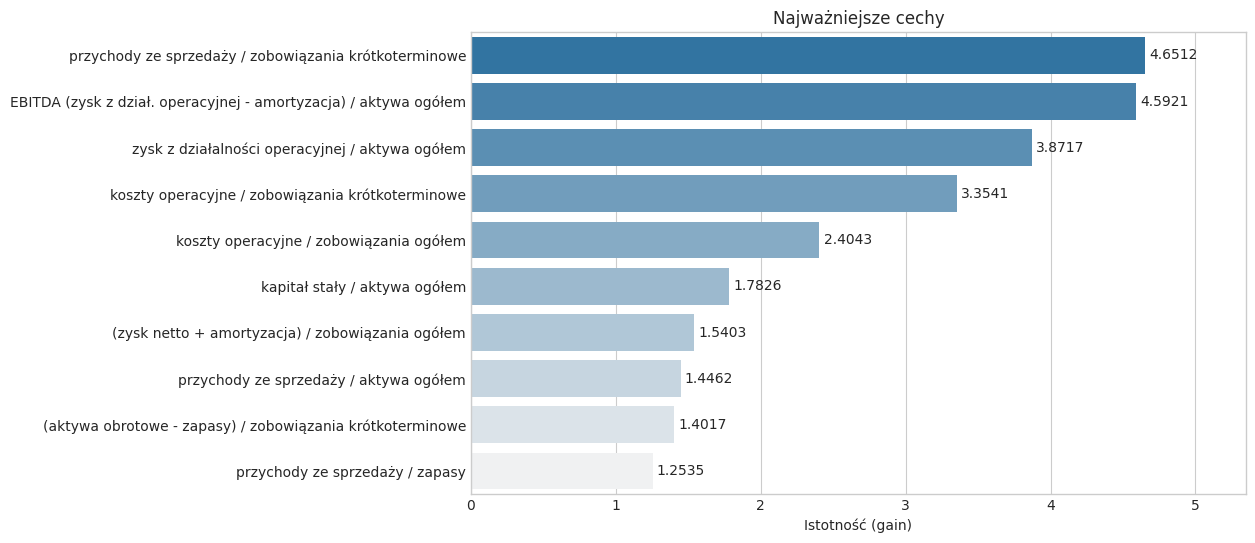

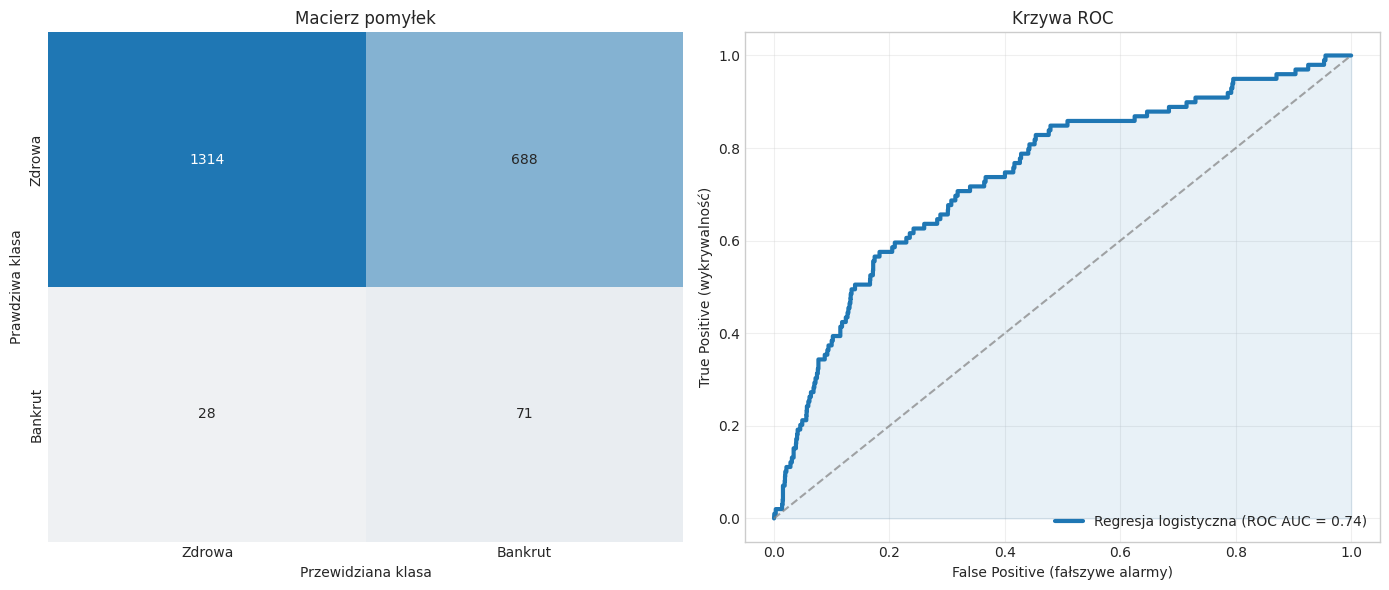

f1_score,▁
recall,▁
roc_auc,▁
f1_score,0.1655
recall,0.71717
roc_auc,0.74177


In [6]:
# 1. KONFIGURACJA RUNU
run_config_base = {
    "model_type": "Baseline (Logistic Regression)",
    "class_weight": "balanced",
    "year": YEAR_TO_ANALYZE,
}

# 2. INICJALIZACJA RUNU
run = wandb.init(
    project="polish-bankruptcy-prediction",
    name=f"Baseline_Logistic_Regression_Year{YEAR_TO_ANALYZE}",
    config=run_config_base,
)

# 3. TRENING
base_model = LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42)

print("Trening modelu bazowego...")
base_model.fit(X_train_scaled, y_train)

# 4. PREDYKCJA
y_pred_base = base_model.predict(X_test_scaled)
y_proba_base = base_model.predict_proba(X_test_scaled)[:, 1]

# 5. WYNIKI
roc_auc_base = roc_auc_score(y_test, y_proba_base)
recall_base = recall_score(y_test, y_pred_base)
f1_score_base = f1_score(y_test, y_pred_base)

print("WYNIKI")
print(f"ROC AUC: {roc_auc_base:.4f}")
print(f"Recall: {recall_base:.4f}")
print(f"F1 Score: {f1_score_base:.4f}")
print("Confusion matrix:")
print(classification_report(y_test, y_pred_base))

# 6. WIZUALIZACJE (macierz pomyłek i krzywa ROC)
# Istotność cech
importances = np.abs(base_model.coef_[0])
feature_imp_df = (
    pd.DataFrame({"Feature": X_train_scaled.columns, "Importance": importances})
    .sort_values(by="Importance", ascending=False)
    .head(10)
)
feature_imp_df["Opis"] = (
    feature_imp_df["Feature"].map(attributes_pl).fillna(feature_imp_df["Feature"])
)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x="Importance",
    y="Opis",
    hue="Opis",
    data=feature_imp_df,
    palette=CMAP_IMPORTANCE,
    legend=False,
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", padding=3)

plt.title("Najważniejsze cechy")
plt.xlabel("Istotność (gain)")
plt.ylabel("")
plt.xlim(0, feature_imp_df["Importance"].max() * 1.15)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Macierz Pomyłek
cm = confusion_matrix(y_test, y_pred_base)

sns.heatmap(cm, annot=True, fmt="d", cmap=CMAP_CONFUSION, cbar=False, ax=ax[0])

ax[0].set_title("Macierz pomyłek")
ax[0].set_xlabel("Przewidziana klasa")
ax[0].set_ylabel("Prawdziwa klasa")
ax[0].set_xticklabels(["Zdrowa", "Bankrut"])
ax[0].set_yticklabels(["Zdrowa", "Bankrut"])

# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_base)

ax[1].plot(
    fpr,
    tpr,
    label=f"Regresja logistyczna (ROC AUC = {roc_auc_base:.2f})",
    color=COLOR_HEALTHY,
    linewidth=3,
)
ax[1].fill_between(fpr, tpr, color=COLOR_HEALTHY, alpha=0.1)
ax[1].plot([0, 1], [0, 1], color="gray", linestyle="--", alpha=0.7)
ax[1].set_xlabel("False Positive (fałszywe alarmy)")
ax[1].set_ylabel("True Positive (wykrywalność)")
ax[1].set_title("Krzywa ROC")
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 7. LOGOWANIE WYNIKÓW DO WANDB
wandb.log(
    {
        "roc_auc": roc_auc_base,
        "recall": recall_base,
        "f1_score": f1_score_base,
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_test.values,
            preds=y_pred_base,
            class_names=["Zdrowa", "Bankrut"],
        ),
        "roc_curve": wandb.plot.roc_curve(
            y_test.values,
            base_model.predict_proba(X_test_scaled),
            labels=["Zdrowa", "Bankrut"],
        ),
        "feature_importance": wandb.plot.bar(
            wandb.Table(dataframe=feature_imp_df[["Feature", "Opis", "Importance"]]),
            "Feature",
            "Importance",
            title="Feature Importance",
        ),
    }
)

run.finish()

## Część 2: Zaawansowane modelowanie

1.  **Random Forest:** Model odporny na overfitting.
2.  **XGBoost:** Obecny standard w konkursach ML.
3.  **Threshold tuning:** Manipulacja progiem decyzyjnym, aby zmaksymalizować wykrywalność bankrutów (recall).
4.  **WandB:** Śledzenie eksperymentów w chmurze.


### Eksperyment 1: Las losowy (random forest)

Zastosowano parametr `class_weight="balanced"`, który automatycznie zwiększa kary za błędy na klasie mniejszościowej (bankrutach).


Szukanie najlepszego modelu (27 kombinacji, 81 treningów)...
Poszukiwania zakończono w 107.19 s
NAJLEPSZE HIPERPARAMETRY:
Liczba drzew (n_estimators): 1000
Głębokość drzew (max_depth): None
Minimalna liczba próbek w liściu (min_samples_leaf): 4


WYNIKI
ROC AUC: 0.8786
Recall: 0.1212
F1 Score: 0.2087
Confusion matrix:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2002
           1       0.75      0.12      0.21        99

    accuracy                           0.96      2101
   macro avg       0.85      0.56      0.59      2101
weighted avg       0.95      0.96      0.94      2101



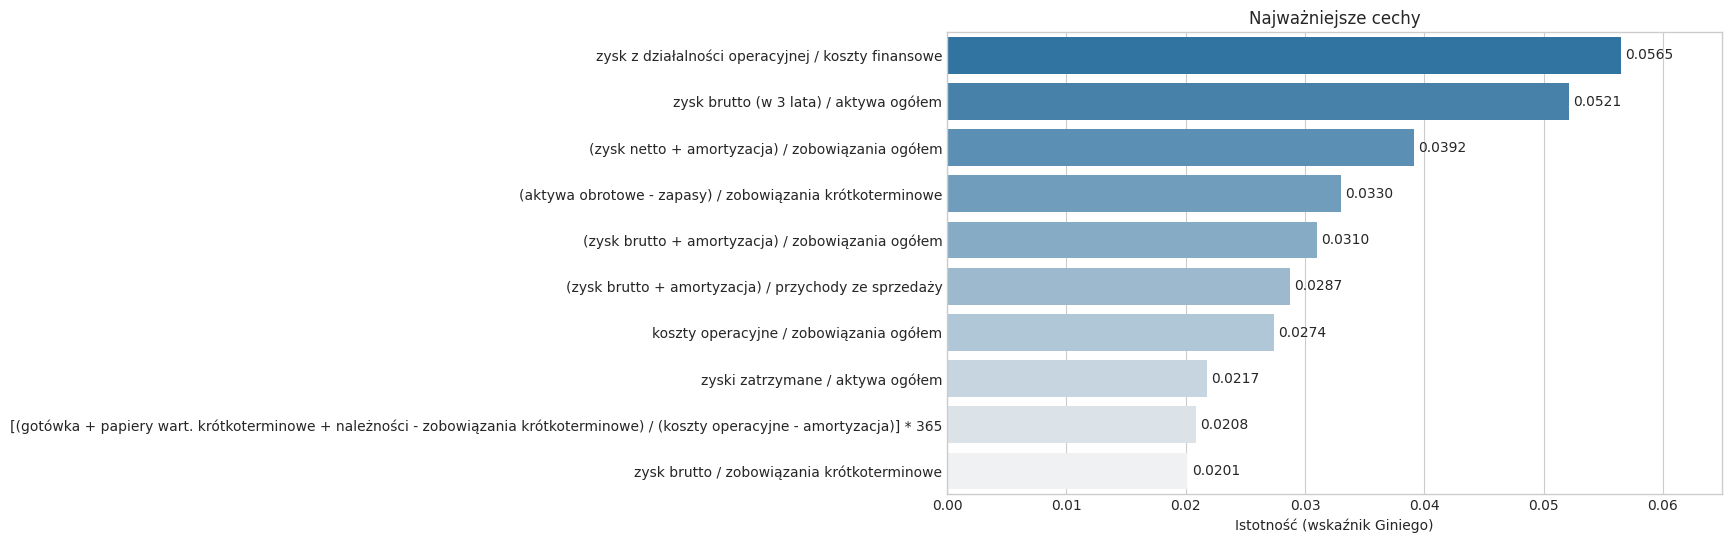

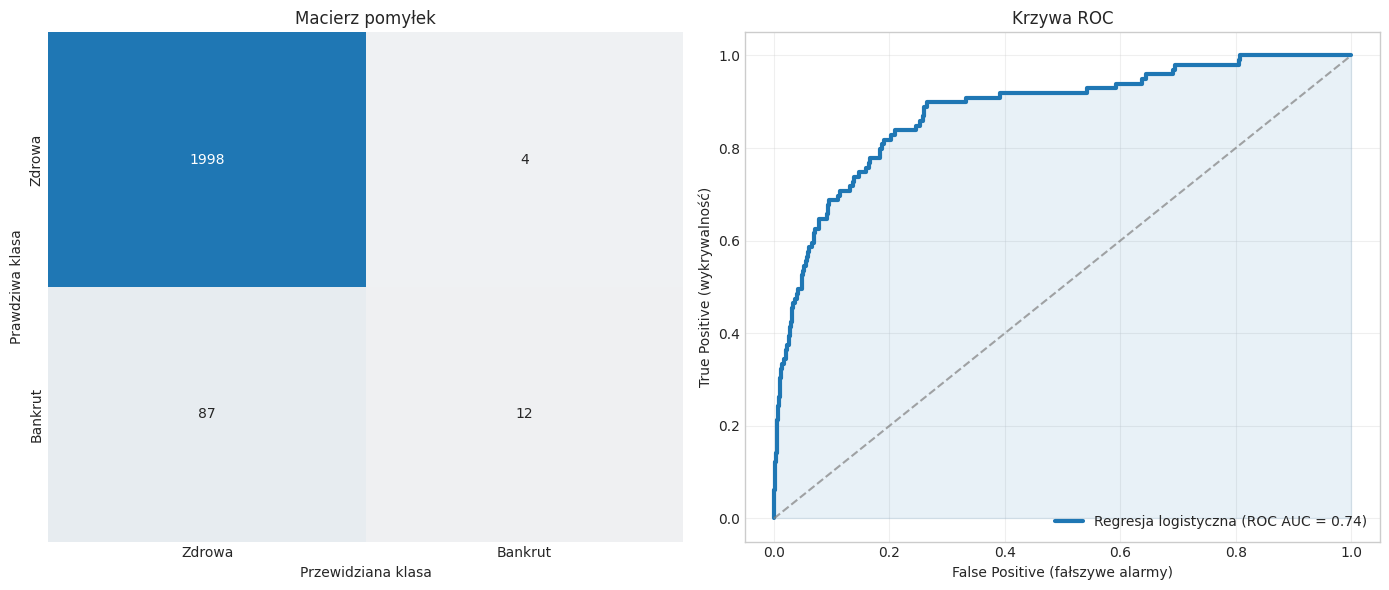

f1_score,▁
recall,▁
roc_auc,▁
f1_score,0.2087
recall,0.12121
roc_auc,0.87858


In [7]:
# 1. DEFINICJA WARIANTÓW PARAMETRÓW
param_grid = {
    "n_estimators": [100, 500, 1000],  # liczba drzew
    "max_depth": [10, 20, None],  # głębokość drzew
    "min_samples_leaf": [1, 2, 4],  # minimalna liczba próbek w liściu
}

fixed_params = {
    "model_type": "Random Forest (Tuned)",
    "class_weight": "balanced",
    "random_state": 42,
    "n_jobs": 1,
    "year": YEAR_TO_ANALYZE,
}

# 2. SZUKANIE NAJLEPSZEGO MODELU
CV_FOLDS = 3  # liczba podziałów walidacji krzyżowej

total_combinations = np.prod([len(v) for v in param_grid.values()])
total_trainings = total_combinations * CV_FOLDS
print(
    f"Szukanie najlepszego modelu ({total_combinations} kombinacji, {total_trainings} treningów)..."
)
start_search = time.time()

rf_temp = RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=1)

grid_search = GridSearchCV(
    estimator=rf_temp,
    param_grid=param_grid,
    scoring="roc_auc",  # szukanie najwyższego ROC AUC
    cv=CV_FOLDS,  # walidacja krzyżowa
    n_jobs=-1,
)

grid_search.fit(X_train_scaled, y_train)

print(f"Poszukiwania zakończono w {time.time() - start_search:.2f} s")

# 3. WYBÓR ZWYCIĘZCY
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("NAJLEPSZE HIPERPARAMETRY:")
print(f"Liczba drzew (n_estimators): {best_params['n_estimators']}")
print(f"Głębokość drzew (max_depth): {best_params['max_depth']}")
print(
    f"Minimalna liczba próbek w liściu (min_samples_leaf): {best_params['min_samples_leaf']}"
)

# 4. KONFIGURACJA RUNU
run_config_best = fixed_params.copy()
run_config_best.update(best_params)

# 5. INICJALIZACJA RUNU
run = wandb.init(
    project="polish-bankruptcy-prediction",
    config=run_config_best,
    name=f"Random_Forest_Tuned_Year{YEAR_TO_ANALYZE}",
)

# 6. EWALUACJA ZWYCIĘZCY
rf_model = best_rf_model

y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_score_rf = f1_score(y_test, y_pred_rf)

print("WYNIKI")
print(f"ROC AUC: {roc_auc_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_score_rf:.4f}")
print("Confusion matrix:")
print(classification_report(y_test, y_pred_rf))

# 7. WIZUALIZACJE
# Istotność cech
importances = rf_model.feature_importances_
feature_imp_df = (
    pd.DataFrame({"Feature": X_train_scaled.columns, "Importance": importances})
    .sort_values(by="Importance", ascending=False)
    .head(10)
)
feature_imp_df["Opis"] = (
    feature_imp_df["Feature"].map(attributes_pl).fillna(feature_imp_df["Feature"])
)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x="Importance",
    y="Opis",
    hue="Opis",
    data=feature_imp_df,
    palette=CMAP_IMPORTANCE,
    legend=False,
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", padding=3)

plt.title("Najważniejsze cechy")
plt.xlabel("Istotność (wskaźnik Giniego)")
plt.ylabel("")
plt.xlim(0, feature_imp_df["Importance"].max() * 1.15)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Macierz Pomyłek
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt="d", cmap=CMAP_CONFUSION, cbar=False, ax=ax[0])

ax[0].set_title("Macierz pomyłek")
ax[0].set_xlabel("Przewidziana klasa")
ax[0].set_ylabel("Prawdziwa klasa")
ax[0].set_xticklabels(["Zdrowa", "Bankrut"])
ax[0].set_yticklabels(["Zdrowa", "Bankrut"])

# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

ax[1].plot(
    fpr,
    tpr,
    label=f"Regresja logistyczna (ROC AUC = {roc_auc_base:.2f})",
    color=COLOR_HEALTHY,
    linewidth=3,
)
ax[1].fill_between(fpr, tpr, color=COLOR_HEALTHY, alpha=0.1)
ax[1].plot([0, 1], [0, 1], color="gray", linestyle="--", alpha=0.7)
ax[1].set_xlabel("False Positive (fałszywe alarmy)")
ax[1].set_ylabel("True Positive (wykrywalność)")
ax[1].set_title("Krzywa ROC")
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 8. LOGOWANIE WYNIKÓW DO WANDB
wandb.log(
    {
        "roc_auc": roc_auc_rf,
        "recall": recall_rf,
        "f1_score": f1_score_rf,
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_test.values,
            preds=y_pred_rf,
            class_names=["Zdrowa", "Bankrut"],
        ),
        "roc_curve": wandb.plot.roc_curve(
            y_test.values,
            rf_model.predict_proba(X_test_scaled),
            labels=["Zdrowa", "Bankrut"],
        ),
        "feature_importance": wandb.plot.bar(
            wandb.Table(
                dataframe=feature_imp_df[["Feature", "Opis", "Importance"]].rename(
                    columns={"Opis": "Description"}
                )
            ),
            "Feature",
            "Importance",
            title="Feature Importance",
        ),
    }
)

run.finish()

### Analiza progu decyzyjnego (threshold tuning)

Większość modeli domyślnie klasyfikuje firmę jako bankruta, jeśli prawdopodobieństwo wynosi $> 50\%$. W przypadku danych niezbalansowanych to podejście często zawodzi – model jest zbyt _ostrożny_.

Poniżej analizowana jest **krzywa precyzja-czułość**, która przedstawia dylemat:

- Czy wykrywać wszystkich bankrutów (**wysoka czułość**), ale mieć dużo fałszywych alarmów?
- Czy mieć pewność, że oznaczone przedsiębiorstwo na pewno zbankrutuje (**wysoka precyzja**), ale wielu zostanie przeoczonych?


Nowy próg decyzyjny: 0.2
WYNIKI
Confusion matrix:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2002
           1       0.31      0.59      0.41        99

    accuracy                           0.92      2101
   macro avg       0.65      0.76      0.68      2101
weighted avg       0.95      0.92      0.93      2101



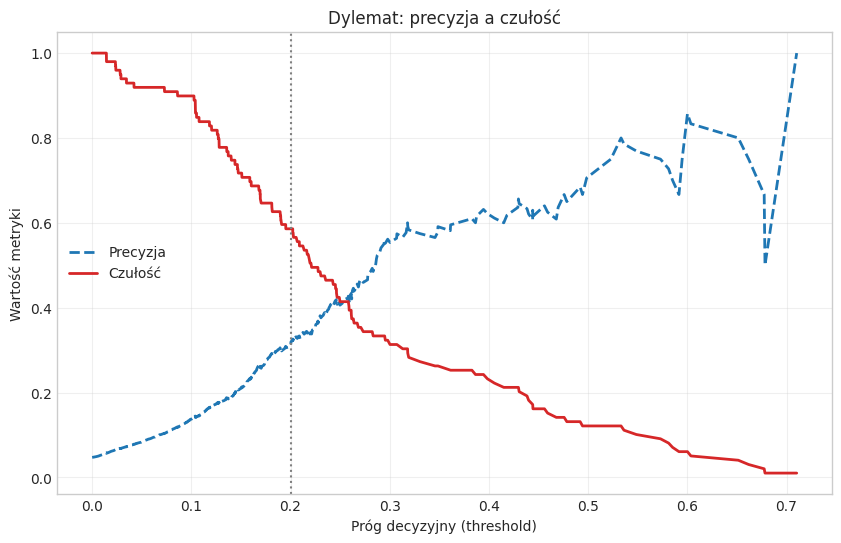

In [8]:
# 1. DEFINICJA NOWEGO PROGU
NEW_THRESHOLD = 0.2
print(f"Nowy próg decyzyjny: {NEW_THRESHOLD}")

# 2. DOSTOSOWANIE PREDYKCJI
y_pred_adjusted = (y_proba_rf >= NEW_THRESHOLD).astype(int)

# 3. SPRAWDZENIE NOWYCH WYNIKÓW
print("WYNIKI")
print("Confusion matrix:")
print(classification_report(y_test, y_pred_adjusted))

# 4. WIZUALIZACJA DYLEMATU
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(
    thresholds,
    precisions[:-1],
    label="Precyzja",
    color=COLOR_HEALTHY,
    linewidth=2,
    linestyle="--",
)
plt.plot(thresholds, recalls[:-1], label="Czułość", color=COLOR_BANKRUPT, linewidth=2)
plt.xlabel("Próg decyzyjny (threshold)")
plt.ylabel("Wartość metryki")
plt.title("Dylemat: precyzja a czułość")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=NEW_THRESHOLD, color="gray", linestyle=":", label=f"Próg {NEW_THRESHOLD}")

plt.show()

### Eksperyment 2: XGBoost (Extreme Gradient Boosting)

Zastosowano parametr `scale_pos_weight`, aby radzić sobie z małą liczbą bankrutów. Parametr mówi modelowi, że **błąd na bankrucie jest X razy bardziej kosztowny** niż błąd na zdrowej firmie.


Wyliczona waga dla klasy bankrutów: 20.22
Szukanie najlepszego modelu (36 kombinacji, 108 treningów)...


/home/jakub/studia/polish-bankruptcy-prediction/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Poszukiwania zakończono w 57.15 s
NAJLEPSZE HIPERPARAMETRY:
Liczba drzew (n_estimators): 500
Głębokość drzew (max_depth): 4
Szybkość uczenia (learning_rate): 0.1


WYNIKI
ROC AUC: 0.9237
Recall: 0.4747
F1 Score: 0.5767
Confusion matrix:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2002
           1       0.73      0.47      0.58        99

    accuracy                           0.97      2101
   macro avg       0.85      0.73      0.78      2101
weighted avg       0.96      0.97      0.96      2101



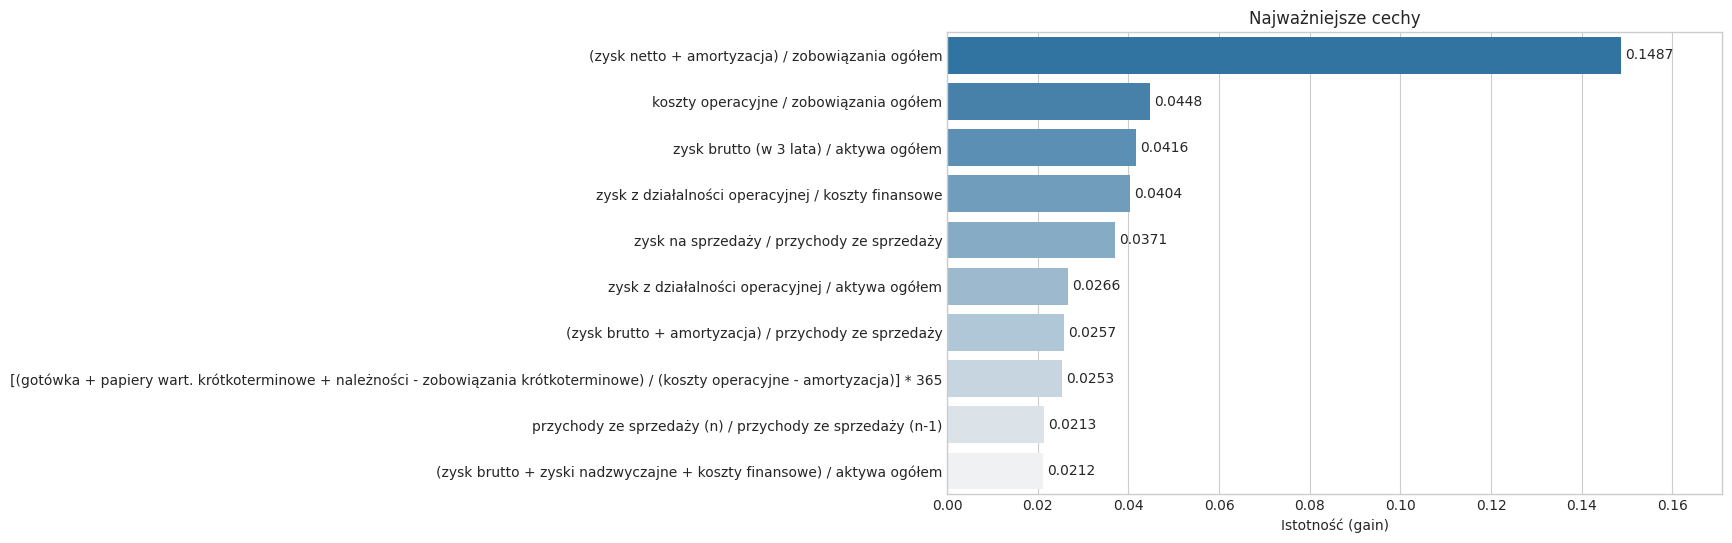

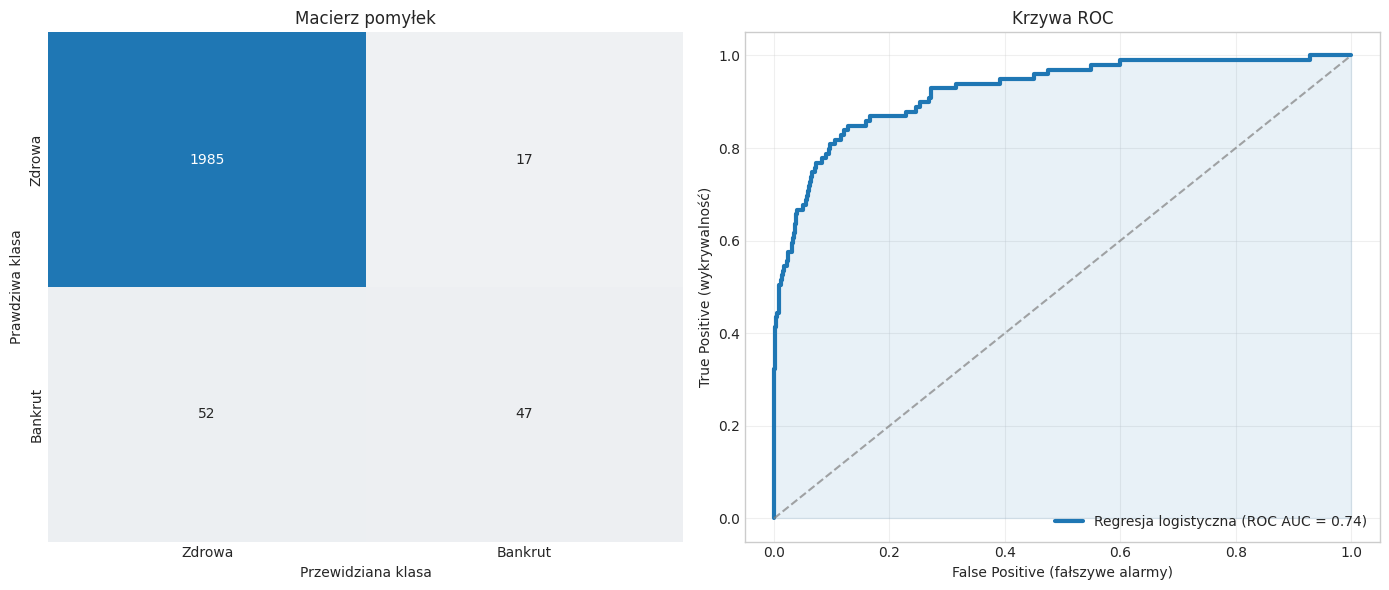

f1_score,▁
recall,▁
roc_auc,▁
f1_score,0.57669
recall,0.47475
roc_auc,0.92365


In [9]:
# 1. OBLICZENIE WAGI KLASY MNIEJSZOŚCIOWEJ
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Wyliczona waga dla klasy bankrutów: {scale_pos_weight:.2f}")

# 2. DEFINICJA WARIANTÓW PARAMETRÓW
param_grid = {
    "n_estimators": [100, 500, 1000],  # liczba drzew
    "max_depth": [4, 6, 8, 10],  # głębokość drzew
    "learning_rate": [0.01, 0.05, 0.1],  # szybkość uczenia
}

fixed_params = {
    "model_type": "XGBoost (Tuned)",
    "scale_pos_weight": scale_pos_weight,
    "random_state": 42,
    "n_jobs": 1,
    "eval_metric": "auc",
    "year": YEAR_TO_ANALYZE,
}

# 3. SZUKANIE NAJLEPSZEGO MODELU
CV_FOLDS = 3  # liczba podziałów walidacji krzyżowej

total_combinations = np.prod([len(v) for v in param_grid.values()])
total_trainings = total_combinations * CV_FOLDS
print(
    f"Szukanie najlepszego modelu ({total_combinations} kombinacji, {total_trainings} treningów)..."
)
start_search = time.time()

xgb_temp = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=1,
    eval_metric="auc",
)

grid_search = GridSearchCV(
    estimator=xgb_temp,
    param_grid=param_grid,
    scoring="roc_auc",  # szukanie najwyższego ROC AUC
    cv=CV_FOLDS,  # walidacja krzyżowa
    n_jobs=-1,
)

grid_search.fit(X_train_scaled, y_train)

print(f"Poszukiwania zakończono w {time.time() - start_search:.2f} s")

# 4. WYBÓR ZWYCIĘZCY
best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("NAJLEPSZE HIPERPARAMETRY:")
print(f"Liczba drzew (n_estimators): {best_params['n_estimators']}")
print(f"Głębokość drzew (max_depth): {best_params['max_depth']}")
print(f"Szybkość uczenia (learning_rate): {best_params['learning_rate']}")

# 5. KONFIGURACJA RUNU
run_config_best = fixed_params.copy()
run_config_best.update(best_params)

# 6. INICJALIZACJA RUNU
run = wandb.init(
    project="polish-bankruptcy-prediction",
    config=run_config_best,
    name=f"XGBoost_Tuned_Year{YEAR_TO_ANALYZE}",
)

# 7. EWALUACJA
xgb_model = best_xgb_model

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_score_xgb = f1_score(y_test, y_pred_xgb)

print("WYNIKI")
print(f"ROC AUC: {roc_auc_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_score_xgb:.4f}")
print("Confusion matrix:")
print(classification_report(y_test, y_pred_xgb))

# 8. WIZUALIZACJE
# Istotność cech
importances = xgb_model.feature_importances_
feature_imp_df = (
    pd.DataFrame({"Feature": X_train_scaled.columns, "Importance": importances})
    .sort_values(by="Importance", ascending=False)
    .head(10)
)
feature_imp_df["Opis"] = (
    feature_imp_df["Feature"].map(attributes_pl).fillna(feature_imp_df["Feature"])
)

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x="Importance",
    y="Opis",
    hue="Opis",
    data=feature_imp_df,
    palette=CMAP_IMPORTANCE,
    legend=False,
)

for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", padding=3)

plt.title("Najważniejsze cechy")
plt.xlabel("Istotność (gain)")
plt.ylabel("")
plt.xlim(0, feature_imp_df["Importance"].max() * 1.15)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Macierz Pomyłek
cm = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm, annot=True, fmt="d", cmap=CMAP_CONFUSION, cbar=False, ax=ax[0])

ax[0].set_title("Macierz pomyłek")
ax[0].set_xlabel("Przewidziana klasa")
ax[0].set_ylabel("Prawdziwa klasa")
ax[0].set_xticklabels(["Zdrowa", "Bankrut"])
ax[0].set_yticklabels(["Zdrowa", "Bankrut"])

# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

ax[1].plot(
    fpr,
    tpr,
    label=f"Regresja logistyczna (ROC AUC = {roc_auc_base:.2f})",
    color=COLOR_HEALTHY,
    linewidth=3,
)
ax[1].fill_between(fpr, tpr, color=COLOR_HEALTHY, alpha=0.1)
ax[1].plot([0, 1], [0, 1], color="gray", linestyle="--", alpha=0.7)
ax[1].set_xlabel("False Positive (fałszywe alarmy)")
ax[1].set_ylabel("True Positive (wykrywalność)")
ax[1].set_title("Krzywa ROC")
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 9. LOGOWANIE WYNIKÓW DO WANDB
wandb.log(
    {
        "roc_auc": roc_auc_xgb,
        "recall": recall_xgb,
        "f1_score": f1_score_xgb,
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_test.values,
            preds=y_pred_xgb,
            class_names=["Zdrowa", "Bankrut"],
        ),
        "roc_curve": wandb.plot.roc_curve(
            y_test.values,
            xgb_model.predict_proba(X_test_scaled),
            labels=["Zdrowa", "Bankrut"],
        ),
        "feature_importance": wandb.plot.bar(
            wandb.Table(
                dataframe=feature_imp_df[["Feature", "Opis", "Importance"]].rename(
                    columns={"Opis": "Description"}
                )
            ),
            "Feature",
            "Importance",
            title="Feature Importance",
        ),
    }
)

run.finish()

### Finalna optymalizacja: Dostrojenie progu pod biznes

W kontekście bankowym/inwestycyjnym koszt przeoczenia bankructwa (utrata kapitału) jest drastycznie wyższy niż koszt sprawdzenia fałszywego alarmu.

Dlatego w tym kroku **nie ufa się domyślnemu progowi**. Ustawiono cel biznesowy na **wykrycie co najmniej 85% bankrutów** (recall $\approx$ 0,85) i sprawdzono, jaki próg prawdopodobieństwa pozwoli to osiągnąć.


Cel: Recall ~ 85.0%
Optymalny próg: 0.0180
WYNIKI
ROC AUC: 0.9237
Recall: 0.8485
F1 Score: 0.3340
Confusion matrix:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2002
           1       0.21      0.85      0.33        99

    accuracy                           0.84      2101
   macro avg       0.60      0.84      0.62      2101
weighted avg       0.95      0.84      0.88      2101



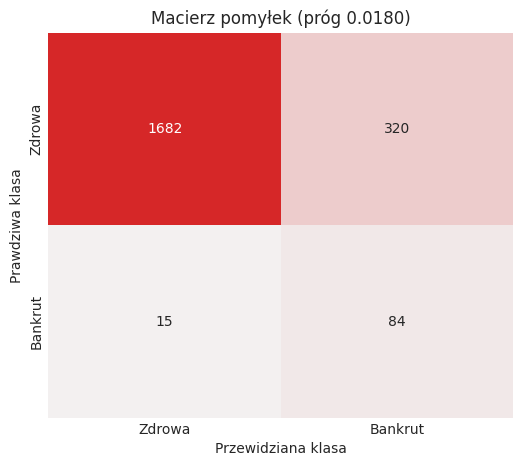

final_f1_score,▁
final_recall,▁
final_roc_auc,▁
optimal_threshold,▁
final_f1_score,0.334
final_recall,0.84848
final_roc_auc,0.92365
optimal_threshold,0.01803


In [10]:
# 1. PRZYGOTOWANIE KONFIGURACJI
opt_config = run_config_best.copy()
opt_config["model_type"] = "XGBoost (Tuned Optimized)"
opt_config["threshold_tuning"] = True

# 2. INICJALIZACJA RUNU
run = wandb.init(
    project="polish-bankruptcy-prediction",
    name=f"XGBoost_Tuned_Optimized_Year{YEAR_TO_ANALYZE}",
    config=opt_config,
)

# 3. PREDYKCJA POCZĄTKOWA
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]  # z poprzedniego kroku

# 4. OPTYMALIZACJA PROGU DECYZYJNEGO
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_xgb)

TARGET_RECALL = 0.85  # cel
optimal_idx = np.argmin(np.abs(recalls - TARGET_RECALL))
optimal_threshold = thresholds[optimal_idx]

print(f"Cel: Recall ~ {TARGET_RECALL * 100}%")
print(f"Optymalny próg: {optimal_threshold:.4f}")

# 5. PREDYKCJA Z NOWYM PROGIEM
y_pred_opt = (y_proba_xgb >= optimal_threshold).astype(int)

# 6. EWALUACJA FINALNA
final_roc_auc = roc_auc_score(y_test, y_proba_xgb)
final_recall = recall_score(y_test, y_pred_opt)
final_f1_score = f1_score(y_test, y_pred_opt)

print("WYNIKI")
print(f"ROC AUC: {final_roc_auc:.4f}")
print(f"Recall: {final_recall:.4f}")
print(f"F1 Score: {final_f1_score:.4f}")
print("Confusion matrix:")
print(classification_report(y_test, y_pred_opt))

# 7. WIZUALIZACJA MACIERZY POMYŁEK
plt.figure(figsize=(6, 5))

cmap_opt = sns.light_palette(COLOR_BANKRUPT, as_cmap=True)

cm = confusion_matrix(y_test, y_pred_opt)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap=cmap_opt,
    cbar=False,
    xticklabels=["Zdrowa", "Bankrut"],
    yticklabels=["Zdrowa", "Bankrut"],
)

plt.title(f"Macierz pomyłek (próg {optimal_threshold:.4f})")
plt.xlabel("Przewidziana klasa")
plt.ylabel("Prawdziwa klasa")
plt.show()

# 8. LOGOWANIE WYNIKÓW DO WANDB
wandb.log(
    {
        "optimal_threshold": optimal_threshold,
        "final_roc_auc": final_roc_auc,
        "final_recall": final_recall,
        "final_f1_score": final_f1_score,
        "final_confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_test.values,
            preds=y_pred_opt,
            class_names=["Zdrowa", "Bankrut"],
        ),
    }
)

run.finish()

### Podsumowanie wyników


,Model,ROC AUC,Recall,F1 Score
0,Baseline (Logistic Regression),0.741771,0.717172,0.165501
1,Random Forest (Tuned),0.878576,0.121212,0.208696
2,XGBoost (Tuned),0.923652,0.474747,0.576687
3,XGBoost (Tuned Optimized),0.923652,0.848485,0.333996


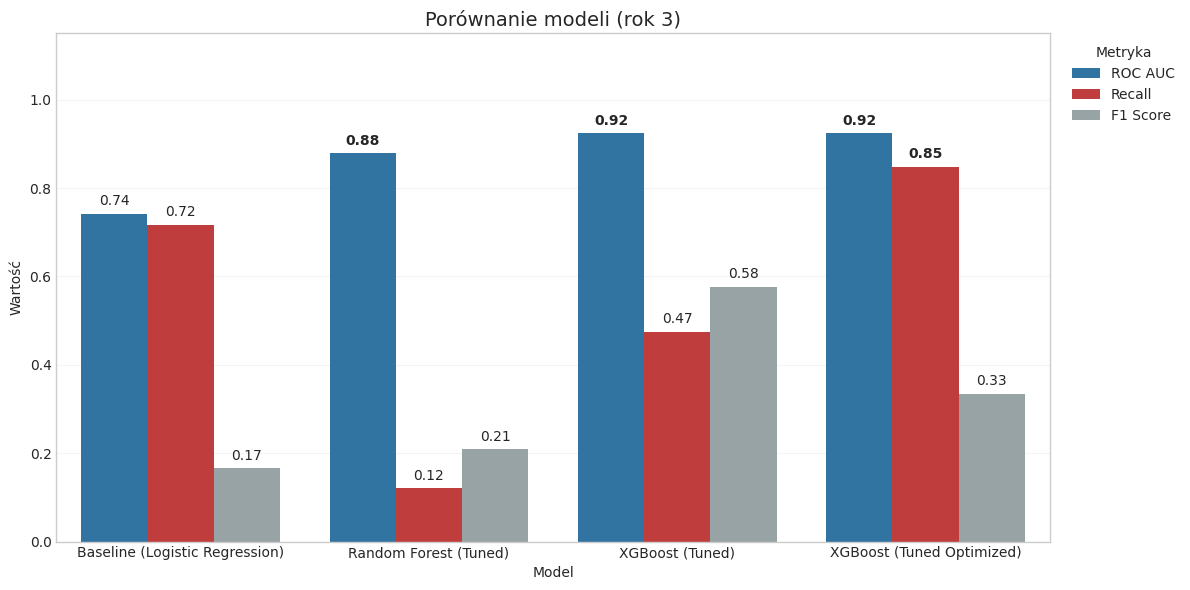

<Figure size 640x480 with 0 Axes>

In [11]:
# 1. ZEBRANIE WYNIKÓW
results_data = {
    "Model": [
        "Baseline (Logistic Regression)",
        "Random Forest (Tuned)",
        "XGBoost (Tuned)",
        "XGBoost (Tuned Optimized)",
    ],
    "ROC AUC": [roc_auc_base, roc_auc_rf, roc_auc_xgb, final_roc_auc],
    "Recall": [recall_base, recall_rf, recall_xgb, final_recall],
    "F1 Score": [f1_score_base, f1_score_rf, f1_score_xgb, final_f1_score],
}

df_results = pd.DataFrame(results_data)

# 2. WYŚWIETLENIE TABELI
display(
    df_results.style.highlight_max(
        axis=0, color=COLOR_BANKRUPT, subset=["ROC AUC", "Recall", "F1 Score"]
    )
)

# 3. WIZUALIZACJA PORÓWNAWCZA
plt.figure(figsize=(12, 6))

df_melted = df_results.melt(id_vars="Model", var_name="Metryka", value_name="Wartość")

metric_colors = {
    "ROC AUC": COLOR_HEALTHY,
    "Recall": COLOR_BANKRUPT,
    "F1 Score": "#95a5a6",
}

# Wykres
sns.barplot(
    data=df_melted, x="Model", y="Wartość", hue="Metryka", palette=metric_colors
)

plt.title(f"Porównanie modeli (rok {YEAR_TO_ANALYZE})", fontsize=14)
plt.ylim(0, 1.15)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", title="Metryka")
plt.grid(axis="y", alpha=0.2)

for p in plt.gca().patches:
    if p.get_height() > 0:
        weight = "bold" if p.get_height() > 0.8 else "normal"

        plt.gca().annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
            fontsize=10,
            fontweight=weight,
        )

plt.tight_layout()
plt.show()

# 4. LOGOWANIE PODSUMOWANIA DO WANDB
run = wandb.init(
    project="polish-bankruptcy-prediction",
    name=f"SUMMARY_Year{YEAR_TO_ANALYZE}",
    job_type="summary",
)

wandb.log(
    {
        "final_summary_table": wandb.Table(dataframe=df_results),
        "model_comparison_plot": wandb.Image(plt),
    }
)

run.finish()

### Zapisanie modeli i progu decyzyjnego


In [12]:
# 1. KONFIGURACJA ŚCIEŻEK
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

# 2. MODELE DO ZAPISU
models_to_save = {
    "Baseline_Logistic_Regression": base_model,
    "Random_Forest_Tuned": best_rf_model,
    "XGBoost_Tuned": best_xgb_model
}

# 3. ZAPIS MODELI
saved_files = []

for name, model in models_to_save.items():
    filepath = os.path.join(models_dir, f"{name}_Year{YEAR_TO_ANALYZE}.joblib")
    joblib.dump(model, filepath)
    saved_files.append(filepath)
    print(f"Zapisano model: {filepath}")

# 4. ZAPIS KONFIGURACJI PROGU DECYZYJNEGO
threshold_info = {
    "model_name": "XGBoost_Tuned",
    "optimal_threshold": float(optimal_threshold),
    "target_metric": "Recall",
    "year": YEAR_TO_ANALYZE
}

threshold_path = os.path.join(models_dir, f"Threshold_Config_Year{YEAR_TO_ANALYZE}.json")
with open(threshold_path, "w") as f:
    json.dump(threshold_info, f, indent=4)

saved_files.append(threshold_path)
print(f"Zapisano konfigurację progu: {threshold_path}")

# 5. WYSŁANIE MODELI DO WANDB
run = wandb.init(
    project="polish-bankruptcy-prediction",
    name=f"SET_Year{YEAR_TO_ANALYZE}",
    job_type="model-save",
)

artifact = wandb.Artifact(
    name=f"all_models_year_{YEAR_TO_ANALYZE}", 
    type="model",
    description="Baseline, Random Forest, XGBoost models + Treshold config"
)

for file in saved_files:
    artifact.add_file(file)

run.log_artifact(artifact)
print("Artefakt wysłany")

run.finish()

Zapisano model: models/Baseline_Logistic_Regression_Year3.joblib
Zapisano model: models/Random_Forest_Tuned_Year3.joblib
Zapisano model: models/XGBoost_Tuned_Year3.joblib
Zapisano konfigurację progu: models/Threshold_Config_Year3.json


Artefakt wysłany
